# StaTexNet - Network Encoding Statistics for Textures
Locally Enforced Connections & Manual Statistics

## Dependencies & Hyperparameters

In [25]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.utils.data as data
from torch.utils.data import DataLoader
import torch.nn as nn
import sys
import matplotlib.pyplot as plt
import numpy as np
from pytorch_metric_learning import losses

import utils.statnetencoder as sne
import imp

#!wget https://raw.githubusercontent.com/pytorch/pytorch/master/torch/utils/collect_env.py

import sys
sys.path.append('../pmetamer')  # Hack to allow importing from pmetamer sibling package/directory

torch.manual_seed(16)

#use GPU 2
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

#hyperparams
num_epochs = 100
batch_size = 20
crop_size = 128
num_stats = 50
optimizer_type='adam'
#optimizer_type='sgd'
learning_rate = 0.001
num_crops = 5

sparsity_penalty = 0.01

#dataset location
dtd_folder = '~/datasets/dtd'

## Define DataLoader

In [36]:
loading_transforms = torchvision.transforms.Compose([#transforms.CenterCrop(size=300),
                                                    #transforms.RandomRotation(degrees=180),
                                                    transforms.Grayscale(),
                                                    #transforms.TenCrop(size=crop_size),
                                                    #transforms.RandomRotation(degrees=[0,90,180,270]),
                                                    transforms.RandomVerticalFlip(p=0.5),
                                                    transforms.RandomHorizontalFlip(p=0.5),
                                                    transforms.FiveCrop(size=crop_size),
                                                    #transforms.functional.vflip(),
                                                    #transforms.functional.hflip(),
                                                    transforms.Lambda(lambda crops: torch.stack([transforms.PILToTensor()(crop) for crop in crops])),
                                                    transforms.ConvertImageDtype(torch.float32)])
                                                    #transforms.PILToTensor()])

#use training set for now
dtd_dataset = torchvision.datasets.DTD(root=dtd_folder, split='train', partition=1, 
                                       transform=loading_transforms, target_transform=None,
                                       download=False)

sampler = data.RandomSampler(dtd_dataset)

dtd_dataloader = DataLoader(dtd_dataset, 
                            sampler=sampler,
                            batch_size=batch_size, 
                            shuffle=False)
#dtd_labels = tf

tensor2pil_transform = transforms.ToPILImage()

print(len(dtd_dataset))

1880


## Test Dataloader

In [5]:
if(False):
    for n, texture_batch in enumerate(dtd_dataloader):
        #grab texture batch and generate matching labels
        output = texture_batch[0].to(device)
        output = torch.flatten(output, start_dim=0, end_dim=1)
        texture_labels = torch.repeat_interleave(torch.arange(batch_size),num_crops)
        #apply random permutation
        perm = torch.randperm(batch_size * num_crops)
        output = output[perm]
        texture_labels = texture_labels[perm]
        print(texture_labels)
        #loop through batch and plot images
        for j in range(batch_size):
            plt.figure(figsize=(8,4))
            for i in range(num_crops):
                plt.subplot(2,5,i+1)
                plt.imshow(tensor2pil_transform(output[i+j*num_crops,:,:,:]),cmap='gray')
                plt.axis('off')
            plt.show()
        if(n==1):
            break;

    tensor2pil_transform(output[4,:,:,:])

## Define Model & Optimizer

In [6]:
imp.reload(sne)
statnet_model = sne.StatNetEncoder(img_size=(crop_size,crop_size),
                                   batch_size=batch_size,
                                   num_stats=num_stats,
                                   device=device)
statnet_model.to(device)
stat_labels = statnet_model.getsstatlabels(device)

#optimizer
if(optimizer_type=='sgd'):
    optimizer = torch.optim.SGD(statnet_model.parameters(), lr=learning_rate)#, momentum=learning_momentum)
elif(optimizer_type=='adam'):
    optimizer = torch.optim.Adam(statnet_model.parameters(), lr=learning_rate)
elif(optimizer_type=='adagrad'):
    optimizer = torch.optim.Adagrad(statnet_model.parameters(), lr=learning_rate)
elif(optimizer_type=='adadelta'):
    optimizer = torch.optim.Adadelta(statnet_model.parameters(), lr=learning_rate)
else:
    print('No Optimizer Specified! Adam is default!')
    optimizer = torch.optim.Adam(statnet_model.parameters(), lr=learning_rate)

Creating solver: pyramid=UBBBBL_6 pooling=WholeImagePooling()


/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


## Statistics

In [7]:
print('Total Stats:',len(stat_labels))
summation=0
for stat in ['edge_mean','edge_variance','edge_stop','edge_correlation','phase_correlation','mean','variance','bandpass_variance','skew','kurtosis']:
    num_this_stat = len([s for s in stat_labels if s.weight_category==stat])
    print(f'{stat} Stat:',num_this_stat)
    summation += num_this_stat
print('Stats Sum to:',summation)
#[s for s in stat_labels] #print all stats with details

Total Stats: 150
edge_mean Stat: 16
edge_variance Stat: 16
edge_stop Stat: 16
edge_correlation Stat: 36
phase_correlation Stat: 48
mean Stat: 1
variance Stat: 6
bandpass_variance Stat: 1
skew Stat: 5
kurtosis Stat: 5
Stats Sum to: 150


## Run Training

In [8]:
imp.reload(sne)
loss_func_contrastive = losses.GeneralizedLiftedStructureLoss()
training_loss = []
training_representation_loss = []
training_sparsity_loss = []
num_total_epochs = 0

statnet_model.train() # Set model to training mode
optimizer.zero_grad()
statnet_model.zero_grad()

In [9]:
retrain=False
#with torch.autograd.set_detect_anomaly(True):
if(retrain):
    print('Starting Training:')
    for i, epoch in enumerate(range(num_total_epochs, num_total_epochs+num_epochs)):
        for j, texture_batch in enumerate(dtd_dataloader):
            #grab texture batch and generate matching labels
            output = texture_batch[0].to(device)
            output = torch.flatten(output, start_dim=0, end_dim=1)
            texture_labels = torch.repeat_interleave(torch.arange(batch_size),num_crops)
            #apply random permutation
            perm = torch.randperm(batch_size * num_crops)
            output = output[perm]
            texture_labels = texture_labels[perm]
            #calculate stats
            stats_vector = statnet_model.forward(output)
            #loss definitions
            #print(stats_vector.shape)
            representation_loss = loss_func_contrastive(stats_vector, texture_labels)
            #norm_loss = torch.norm(statnet_model.compressor[0].weight,p=1) #soft constraint
            sparsity_loss = 0 #torch.abs(statnet_model.compressor[0].weight).sum()
            loss = representation_loss + (sparsity_penalty * sparsity_loss) #+ norm_loss
            optimizer.step()
            optimizer.zero_grad()
            loss.backward()

            print('*',end='')
            #training_loss.append(loss.item())      
            if(j%30==0):
                print(loss.item())
                
            training_representation_loss.append(representation_loss.item())
            training_sparsity_loss.append(loss.item())
            training_loss.append(loss.item())
        num_total_epochs = num_total_epochs + 1


        print(f'Finished Epoch {i}. Loss at {loss}.')
        if(i%10==0):
            compressor_mat = statnet_model.compressor[0].weight.data.cpu().numpy()
            plt.imshow(compressor_mat)
            plt.colorbar() 
            plt.show()
    torch.save(
            {'state_dict': statnet_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'training_loss':training_loss,
            'last_output':output,
            'last_statvec':stats_vector},
            f'./model_checkpoint_epoch_{i}.pth')
else:
    print('Loading model')
    i=99
    loaded_dict = torch.load(f'./model_checkpoint_epoch_{i}.pth')
    statnet_model.load_state_dict(loaded_dict['state_dict'])
    optimizer.load_state_dict(loaded_dict['optimizer_state_dict'])
    training_loss = loaded_dict['training_loss']
    output = loaded_dict['last_output']
    stats_vector = loaded_dict['last_statvec']
    statnet_model.eval()
print('All Done!')

Loading model
All Done!


Text(0.5, 1.0, 'Training Loss')

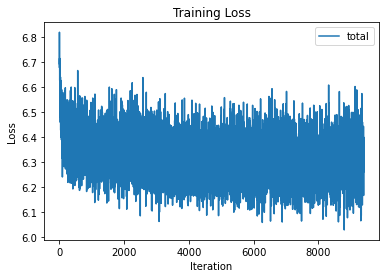

In [10]:
plt.plot(training_loss,label='total')
#plt.plot(training_representation_loss,label='representation')
#plt.plot(training_sparsity_loss,label='sparity')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.title('Training Loss')


## Visualizing weights:
    Visualize weight matrix as in sparse coding 

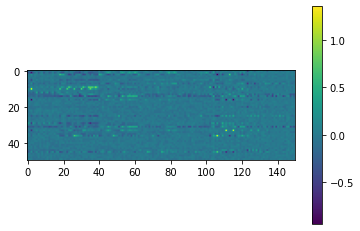

In [11]:
compressor_mat = statnet_model.compressor[0].weight.data.cpu().numpy()
plt.imshow(compressor_mat)
plt.colorbar()

## Visualizing weights:
    Which weights are highest magnitude (and what labels do these correspond to?)

Most Important 25 Stats:
8.421789 bandpass_variance 0
7.222809 phase_correlation 1 er (1, 3)
7.130596 edge_correlation 1 (0, 2)
6.626595 phase_correlation (1, 2) er*di 1
6.4559946 edge_correlation 1 (1, 3)
6.343789 phase_correlation (1, 2) er*di 3
6.2532415 edge_mean 1 0
6.1097674 phase_correlation (2, 3) er*di 0
6.0199428 edge_variance 1 3
5.9570985 phase_correlation (1, 2) er*di 0
5.9432755 edge_variance 1 1
5.850473 edge_correlation 1 (0, 1)
5.783001 phase_correlation 1 er (0, 3)
5.7383046 edge_mean 1 2
5.7207985 edge_variance 2 1
5.645076 edge_stop 1 2
5.6415257 edge_mean 1 3
5.611299 edge_correlation 1 (1, 2)
5.5834208 phase_correlation 2 er (1, 3)
5.5800505 edge_variance 2 3
5.5164237 edge_mean 1 1
5.510078 edge_correlation 1 (0, 3)
5.4419303 edge_correlation 1 (2, 3)
5.3481913 edge_variance 1 0
5.3313193 phase_correlation 1 er (0, 1)


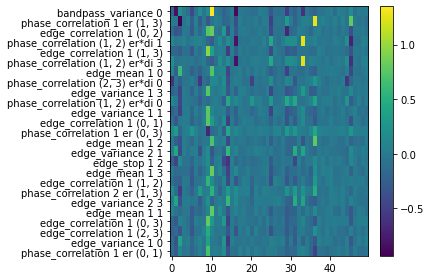

Least Important 25 Stats:
0.9250399 edge_stop 3 0
1.1794754 phase_correlation (3, 4) ei*di 3
1.3478141 edge_stop 3 1
1.3539512 edge_stop 2 1
1.3619765 edge_stop 4 0
1.3648254 phase_correlation (3, 4) ei*di 2
1.4679316 phase_correlation (3, 4) ei*di 1
1.4916925 edge_stop 4 1
1.4945519 edge_stop 1 0
1.5486485 phase_correlation (3, 4) ei*di 0
1.5659249 edge_stop 4 3
1.64508 edge_stop 1 3
1.6577237 edge_stop 2 3
1.6819798 edge_stop 1 1
1.7771797 phase_correlation (2, 3) ei*di 0
1.8790295 edge_stop 3 3
1.8875936 edge_stop 2 0
1.9995595 phase_correlation (1, 2) ei*di 2
2.0219812 phase_correlation (2, 3) ei*di 2
2.0590394 phase_correlation (1, 2) ei*di 1
2.144114 edge_stop 4 2
2.2043097 phase_correlation (1, 2) ei*di 3
2.2410517 phase_correlation 4 er (0, 3)
2.2618542 phase_correlation (2, 3) ei*di 1
2.2631946 phase_correlation (1, 2) ei*di 0


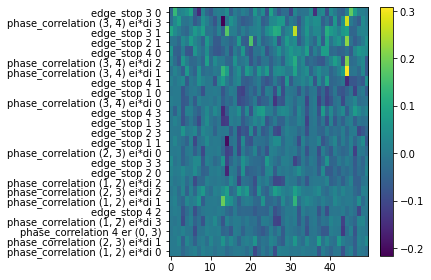

In [12]:
stat_sums = np.sum(np.abs(compressor_mat),axis=0) #how weighted is each of the 150 stats?
stat_index_array = np.argsort(stat_sums)[::-1] #get their importance order

ordered_stat_sums = stat_sums[stat_index_array]
ordered_stat_labels = np.array(stat_labels,dtype=object)[stat_index_array]
ordered_stats_labels_pretty = [' '.join([''.join(str(item)) for item in row if item not in ['',None]]) for row in ordered_stat_labels]

n=25
print(f'Most Important {n} Stats:')
for i in range(n):
    print(ordered_stat_sums[i],ordered_stats_labels_pretty[i])

#plot the most important stats for contrastive learning
fig, ax = plt.subplots()
im = ax.imshow(compressor_mat[:,stat_index_array[:n]].T, aspect='auto')
fig.colorbar(im)
# Show all ticks and label them with the respective list entries
top_stats = ordered_stats_labels_pretty[:n]
ax.set_yticks(np.arange(len(top_stats)), labels=top_stats)
#Rotate the tick labels and set their alignment.
#plt.setp(ax.get_yticklabels(), rotation=45, ha="right",
#         rotation_mode="anchor")
plt.tight_layout()
plt.show()    
    
#plot most important stats for contrastive learning
#plt.imshow(compressor_mat[:,stat_index_array[:n]].T)

print(f'Least Important {n} Stats:')
for i in range(1,n+1):
    print(ordered_stat_sums[-i],ordered_stats_labels_pretty[-i])
    
    
#plot the most important stats for contrastive learning
fig, ax = plt.subplots()
im = ax.imshow(compressor_mat[:,stat_index_array[-n:]].T, aspect='auto')
fig.colorbar(im)
# Show all ticks and label them with the respective list entries
bot_stats = ordered_stats_labels_pretty[-n:][::-1]
ax.set_yticks(np.arange(len(bot_stats)), labels=bot_stats)
#Rotate the tick labels and set their alignment.
#plt.setp(ax.get_yticklabels(), rotation=45, ha="right",
#         rotation_mode="anchor")
plt.tight_layout()
plt.show()    


## Load in Test Set

In [27]:
#use training set for now
dtd_testset = torchvision.datasets.DTD(root=dtd_folder, split='test', partition=1, 
                                       transform=loading_transforms, target_transform=None,
                                       download=False)

test_sampler = data.RandomSampler(dtd_testset)

dtd_testloader = DataLoader(dtd_testset, 
                            sampler=test_sampler,
                            batch_size=batch_size, 
                            shuffle=False)

In [28]:
for n, texture_batch in enumerate(dtd_testloader):
    output = texture_batch[0].to(device)
    output = torch.flatten(output, start_dim=0, end_dim=1)
    texture_labels = torch.repeat_interleave(torch.arange(batch_size),num_crops)
    #apply random permutation
    perm = torch.randperm(batch_size * num_crops)
    output = output[perm]
    texture_labels = texture_labels[perm]
    #calculate stats
    stats_vector = statnet_model.forward(output)
    break;
        

## Visualizing representation:
    Visualize t-SNE of textures in latent space
    most similar and most different textures

In [29]:
stats_vector.shape

torch.Size([100, 50])

In [30]:
from tsne_torch import TorchTSNE as TSNE

#texture_labels
#output
#calculate stats
stats_vector = statnet_model.forward(output)
print(stats_vector.shape)

X = stats_vector  # shape (n_samples, d)
X_emb = TSNE(n_components=2, perplexity=10, n_iter=10000, verbose=True).fit_transform(X)  # returns shape (n_samples, 2)

torch.Size([100, 50])


using cuda
initializing...
skipping PCA because initial_dims is larger than input dimensionality
computing p-values...


  0%|          | 0/100 [00:00<?, ?it/s]

fitting...


  0%|          | 0/10000 [00:00<?, ?it/s]

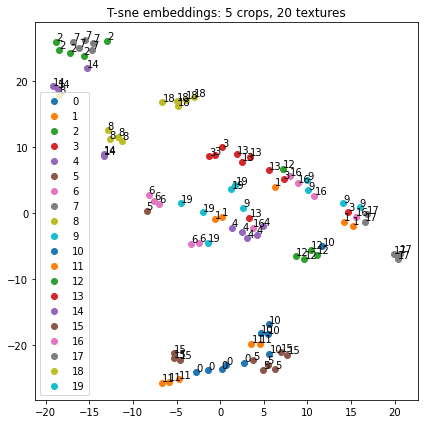

In [31]:
#plt.legend(handles=scatter.legend_elements()[0], labels=texture_labels, title="Textures")
texture_label_list = texture_labels.numpy()

#fig, ax = plt.subplots()
#scatter = ax.scatter(X_emb[:,0],X_emb[:,1],c=texture_label_list,label=texture_label_list)
#plt.legend()#handles=scatter.legend_elements()[0], labels=texture_label_list)

#plt.legend()
#plt.legend(handles=scatter.legend_elements()[0],title="texture")

#handles = [plt.plot([],color=sc.get_cmap()(sc.norm(c)),ls="", marker="o")[0] for c,l in clset ]
#labels = [l for c,l in clset]
#ax.legend(texture_label_list)

unique_textures = set(texture_label_list)

#fix, ax = plt.subplots()
plt.figure(figsize=(6,6))
for i in range(len(unique_textures)):
    texture_index = np.where(texture_label_list==i)
    plt.scatter(X_emb[texture_index,0],X_emb[texture_index,1],label=i)
plt.legend()
plt.title(f'T-sne embeddings: {num_crops} crops, {batch_size} textures')
plt.tight_layout()

for i, label in enumerate(texture_label_list):
    plt.annotate(label, (X_emb[i,0],X_emb[i,1] + 0.2))

#for i, txt in enumerate(texture_label_list):
#    plt.annotate(texture_label_list, (X_emb[:,0],X_emb[:,1]))
plt.tight_layout()


Texture 7
[11 31 36 41 84]


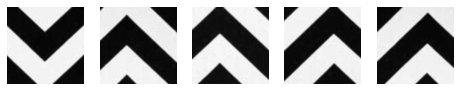

Texture 2
[18 26 76 89 96]


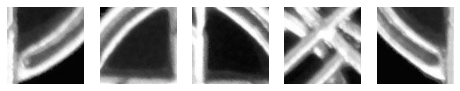

Texture 14
[ 5 17 21 61 93]


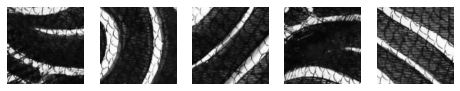

Texture 8
[12 14 25 65 80]


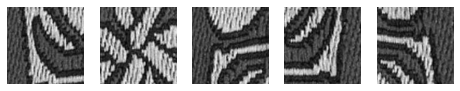

Texture 10
[22 74 75 79 86]


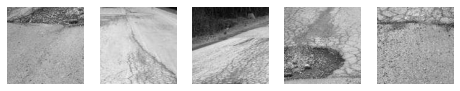

Texture 15
[ 0 33 44 51 91]


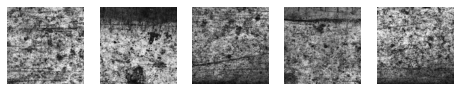

Texture 11
[ 1 10 27 32 39]


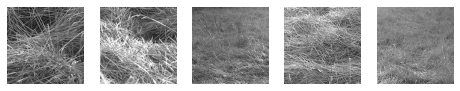

Texture 0
[ 2 34 77 95 99]


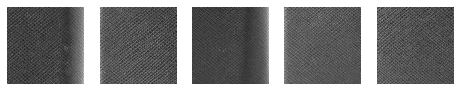

Texture 9
[47 55 68 78 92]


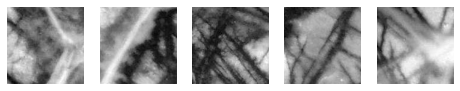

Texture 16
[ 3 30 50 87 97]


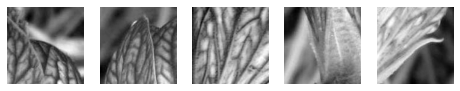

In [35]:
#look at textures 12 and 14

def plot_textures(n,texture_labels,img_tensor): 
    texture_indices = np.where(texture_labels.numpy()==n)[0]
    print(texture_indices)
    textures = img_tensor[texture_indices,:,:,:]
    plt.figure(figsize=(8,4))
    for i,idx in enumerate(texture_indices):
        plt.subplot(1,num_crops,i+1)
        plt.imshow(tensor2pil_transform(textures[i,:,:,:]),cmap='gray')
        plt.axis('off')
    plt.show()
    
print('Texture 7')
plot_textures(7,texture_labels,output)
print('Texture 2')
plot_textures(2,texture_labels,output)
print('Texture 14')
plot_textures(14,texture_labels,output)
print('Texture 8')
plot_textures(8,texture_labels,output)

print('Texture 10')
plot_textures(10,texture_labels,output)
print('Texture 15')
plot_textures(15,texture_labels,output)
print('Texture 11')
plot_textures(11,texture_labels,output)
print('Texture 0')
plot_textures(0,texture_labels,output)

print('Texture 9')
plot_textures(9,texture_labels,output)
print('Texture 16')
plot_textures(16,texture_labels,output)

In [34]:
output.shape

torch.Size([100, 1, 128, 128])

In [16]:
filter = statnet_model.fc.weight.data.numpy()
#(1/(2*(maximum negative value)))*filter+0.5 === you need to normalize the filter before plotting.
filter = (1/(2*3.69201088))*filter + 0.5 #Normalizing the values to [0,1]

#num_cols= choose the grid size you want
def plot_kernels(tensor, num_cols=8):
    if not tensor.ndim==4:
        raise Exception("assumes a 4D tensor")
    if not tensor.shape[-1]==3:
        raise Exception("last dim needs to be 3 to plot")
    num_kernels = tensor.shape[0]
    num_rows = 1+ num_kernels // num_cols
    fig = plt.figure(figsize=(num_cols,num_rows))
    for i in range(tensor.shape[0]):
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)
        ax1.imshow(tensor[i])
        ax1.axis('off')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])

    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()
    
    
plot_kernels(filter)

AttributeError: 'StatNetEncoder' object has no attribute 'fc'

## Visualizing Reduction
    Run BruceNet Solver with reduced texture set

In [ ]:
stat_labels

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ",".join([str(gpu) for gpu in args.gpus])

print("Available/CUDA_VISIBLE_DEVICES", os.environ["CUDA_VISIBLE_DEVICES"])


In [ ]:
n#steerable pyramid

im_batch = im_batch.to(device).float()

pyr_torch = SCFpyr_PyTorch(pyr_height, pyr_nbands, device=device)
coeff_torch = pyr_torch.build(im_batch)

In [ ]:
output.shape

In [ ]:
?list.insert